# Variational Quantum Eigensolver

### Victor Onofre

This was the screening task for the Quantum Computing Mentorship Program in the Quantum Open Source Foundation (https://qosf.org/)

Find the lowest eigenvalue of the following matrix:

\begin{equation}
       H = 
       \begin{bmatrix} 
        1  & 0  &  0 & 0  \cr
        0  & 0  & -1 & 0  \cr
        0  & -1 &  0 & 0  \cr
        0  & 0  &  0 & 1  \cr \end{bmatrix} 
\end{equation}

using VQE-like circuits, created by yourself from scratch.

# Part I : Decomposing the matrix to the sum of Pauli terms

In [1]:
import qutip as qt # I use QuTip for the tensor and trace function
import numpy as np 

In [2]:
H = qt.Qobj(np.matrix([[1.0   , 0.0 , 0.0 , 0.0 ]
                      ,[0.0   , 0.0 ,-1.0 , 0.0 ]
                      ,[0.0   ,-1.0 , 0.0 , 0.0 ] 
                      ,[0.0   , 0.0 , 0.0 , 1.0 ]]))

\begin{equation}
       H = 
       \begin{bmatrix} 
        1  & 0  &  0 & 0  \cr
        0  & 0  & -1 & 0  \cr
        0  & -1 &  0 & 0  \cr
        0  & 0  &  0 & 1  \cr \end{bmatrix} 
\end{equation}

In [3]:
H

Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 1.  0.  0.  0.]
 [ 0.  0. -1.  0.]
 [ 0. -1.  0.  0.]
 [ 0.  0.  0.  1.]]

In [4]:
Id = qt.qeye(2); Sx = qt.sigmax(); Sy = qt.sigmay(); Sz = qt.sigmaz();

\begin{equation}
       Id = \sigma_{0} = 
       \begin{bmatrix} 
        1  & 0  \cr
        0  & 1  \cr \end{bmatrix}  \qquad  
       Sx =  \sigma_{1} = 
       \begin{bmatrix} 
        0  & 1  \cr
        1  & 0 \cr \end{bmatrix}  \qquad
        Sy = \sigma_{2} = 
       \begin{bmatrix} 
        0  & -i  \cr
        i  & 0 \cr \end{bmatrix}  \qquad
       Sz = \sigma_{3} = 
       \begin{bmatrix} 
        1  & 0  \cr
        0  & -1 \cr \end{bmatrix}  \qquad
\end{equation}


In [5]:
Pauli = [Id,Sx,Sy,Sz]
PauliLabels = ['Id' , 'Sx' , 'Sy' , 'Sz'] 
aij  = 0;

\begin{equation}
 H = \sum_{i,j = 0,1,2,3,4} a_{i,j} (\sigma_{i} \otimes \sigma_{j}) \qquad a_{i,j} = 0.25*Tr [ (\sigma_{i} \otimes \sigma_{j}) H ]
\end{equation}

In [6]:
for i in range(4):
    for j in range(4):
        PauliTensor = qt.Qobj(qt.tensor(Pauli[i], Pauli[j]).data.toarray(),dims=[[4],[4]]) # Tensor product of the pauli matrices (sigma_i (tensor) sigma_j), dims[[4],[4]] equal to dimens of  H
        aij = 0.25*( (PauliTensor*H ).tr()) #Elements of the descomposition
        label1 = PauliLabels[i] #Label i to print
        label2 = PauliLabels[j] #Label j to print
        if aij!= 0:
            print(aij, '*', label1, '(tensor)', label2 ) # Print the descomposition of the matrix 

0.5 * Id (tensor) Id
-0.5 * Sx (tensor) Sx
-0.5 * Sy (tensor) Sy
0.5 * Sz (tensor) Sz


The descomposition of the matrix  $H$  to the sum of Pauli terms is:

\begin{equation}
 H = 0.5*(\sigma_{0} \otimes \sigma_{0}) - 0.5* (\sigma_{1} \otimes \sigma_{1})- 0.5* (\sigma_{2} \otimes \sigma_{2}) + 0.5* (\sigma_{3} \otimes \sigma_{3}) =  \begin{bmatrix} 
        1  & 0  &  0 & 0  \cr
        0  & 0  & -1 & 0  \cr
        0  & -1 &  0 & 0  \cr
        0  & 0  &  0 & 1  \cr \end{bmatrix} 
\end{equation}

In [7]:
Id_tensor_Id = qt.tensor(Pauli[0], Pauli[0]) 
sx_tensor_sx = qt.tensor(Pauli[1], Pauli[1]) 
sy_tensor_sy = qt.tensor(Pauli[2], Pauli[2]) 
sz_tensor_sz = qt.tensor(Pauli[3], Pauli[3]) 

In [8]:
H_descomposition = 0.5*Id_tensor_Id - 0.5*sx_tensor_sx  - 0.5*sy_tensor_sy + 0.5*sz_tensor_sz
H_descomposition_Dim = qt.Qobj(H_descomposition.data.toarray(),dims=[[4],[4]])

In [9]:
H_descomposition_Dim

Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 1.  0.  0.  0.]
 [ 0.  0. -1.  0.]
 [ 0. -1.  0.  0.]
 [ 0.  0.  0.  1.]]

# Part II : Variational-Quantum-Eigensolver

In the Variational Quantum Eigensolver (VQE) algorithm we want to  known the lowest eigenvalue of the matriz $H$ using a classical minimization in combination with a quantum circuit, is a hybrid quantum-classical algortihm. The algorithm consists of the steps [1] :
* Prepare an initial state |0> 
* Genarate an ansatz quantum satate $|{\psi(\theta)} >$ by applying a quantum circuit $U(\theta)$ parametrize by (classical) parameters $\theta$, $|{\psi(\theta)} > = U (\theta)|0>$
* The expectation value of the Hamiltonian $H$ is measured which is denoted as
\begin{equation}
E (\theta)= <{\psi(\theta)} | H |{\psi(\theta)} >
\end{equation}
* Update the parameters $\theta$ to get $E(\theta)$ smaller by using classical optimizing algorithm
* Repeat steps until convergence

In this case we have 
\begin{equation}
 H = 0.5*(\sigma_{0} \otimes \sigma_{0}) - 0.5* (\sigma_{1} \otimes \sigma_{1})- 0.5* (\sigma_{2} \otimes \sigma_{2}) + 0.5* (\sigma_{3} \otimes \sigma_{3}) 
\end{equation}
And the expectation value is
\begin{equation}
 <H> = 0.5* <{\psi(\theta)} | ( \sigma_{0} \otimes \sigma_{0} ) |{\psi(\theta)} >  - 0.5*  <{\psi(\theta)} | (\sigma_{1} \otimes \sigma_{1}) |{\psi(\theta)} > - 0.5*  <{\psi(\theta)} | (\sigma_{2} \otimes \sigma_{2}) |{\psi(\theta)} > + 0.5* <{\psi(\theta)} |  (\sigma_{3} \otimes \sigma_{3}) |{\psi(\theta)} >
\end{equation}

In [10]:
from qiskit import QuantumCircuit, Aer, execute 
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

# Ansatz: $(Rx \otimes I) (CX) (H \otimes I) |00>$

Circuit to apply the ansatz

In [11]:
def ansatz(circuit,angle):
    circuit.h(0);         circuit.id(1) #Apply (H \otimes I) |00>
    circuit.cx(0,1)                     #Apply (CX) 
    circuit.rx(angle, 0); circuit.id(1) #Apply (Rx \otimes I)
    return circuit

Example of the ansatz for $\theta = \pi/4$

In [12]:
ansatzCircuit = QuantumCircuit(2)
ansatzCircuit = ansatz(ansatzCircuit,np.pi/4)
ansatzCircuit.draw()

┌───┐     ┌──────────┐
q_0: ┤ H ├──■──┤ RX(pi/4) ├
     ├───┤┌─┴─┐└──┬───┬───┘
q_1: ┤ I ├┤ X ├───┤ I ├────
     └───┘└───┘   └───┘

\begin{equation}
       \sigma_{3} = 
       \begin{bmatrix} 
        1  & 0  \cr
        0  & -1 \cr \end{bmatrix}  \qquad \sigma_{3} |0> = (+1)|0> \quad \sigma_{3} |1> = (-1)|1>
\end{equation}

Any $2×2$ matrix that is a unitary transformation of $\sigma_{3}$ also satisfies this criteria. 
That is, we could also use a matrix $A=U^{\dagger} \sigma_{3}U$, where $U$ is any other unitary matrix, to give a matrix that defines the two outcomes of a measurement in its $±1$ eigenvectors [2].

**Circuit to measure $(\sigma_{3} \otimes \sigma_{3})$**

In [13]:
def zz_meas(angle):
    qc = QuantumCircuit(2) # qc is the quantum register of the qubits, in this case 2 qubits
    qc = ansatz(qc,angle)
    qc.measure_all()
    return qc 

Example of the circuit for $\theta = \pi/4$

In [14]:
zz = zz_meas(np.pi/4)
zz.draw()

┌───┐     ┌──────────┐ ░ ┌─┐   
   q_0: ┤ H ├──■──┤ RX(pi/4) ├─░─┤M├───
        ├───┤┌─┴─┐└──┬───┬───┘ ░ └╥┘┌─┐
   q_1: ┤ I ├┤ X ├───┤ I ├─────░──╫─┤M├
        └───┘└───┘   └───┘     ░  ║ └╥┘
meas_0: ══════════════════════════╩══╬═
                                     ║ 
meas_1: ═════════════════════════════╩═

**Circuit to measure $(\sigma_{2} \otimes \sigma_{2})$**

Measure $\sigma_{2}$ is equivalent to applying $H S^{\dagger}$ (H=Hadamard) and then measuring in the computational basis. Where 
\begin{equation}
       S^{\dagger} = 
       \begin{bmatrix} 
        1  & 0  \cr
        0  & -i \cr \end{bmatrix}  \qquad 
        H = \frac{1}{\sqrt{2}} 
       \begin{bmatrix} 
        1  & 1  \cr
        1  & -1 \cr \end{bmatrix}  \qquad
\end{equation}
\begin{equation}
\sigma_{2} =  (H S)\sigma_{3} (H S^{\dagger}) \quad Y = (H S) Z (H S^{\dagger})
\end{equation}


In [15]:
def yy_meas(angle):
    qc = QuantumCircuit(2)  # qc is the quantum register of the qubits, in this case 2 qubits
    qc = ansatz(qc,angle)
    qc.barrier()
    
    qc.h(0);  qc.h(1)   #Apply (H \otimes H) |00>
    qc.sdg(0); qc.sdg(1) #Apply (S^{\dagger} \otimes S^{\dagger}) 
    qc.measure_all()
    return qc 

Example of the circuit for $\theta = \pi/4$

In [16]:
yy = yy_meas(np.pi/4)
yy.draw()

┌───┐     ┌──────────┐ ░ ┌───┐┌─────┐ ░ ┌─┐   
   q_0: ┤ H ├──■──┤ RX(pi/4) ├─░─┤ H ├┤ SDG ├─░─┤M├───
        ├───┤┌─┴─┐└──┬───┬───┘ ░ ├───┤├─────┤ ░ └╥┘┌─┐
   q_1: ┤ I ├┤ X ├───┤ I ├─────░─┤ H ├┤ SDG ├─░──╫─┤M├
        └───┘└───┘   └───┘     ░ └───┘└─────┘ ░  ║ └╥┘
meas_0: ═════════════════════════════════════════╩══╬═
                                                    ║ 
meas_1: ════════════════════════════════════════════╩═

**Circuit to measure $(\sigma_{1} \otimes \sigma_{1})$**

Measure $\sigma_{1}$ is equivalent to applying $H$ (H=Hadamard) and then measuring in the computational basis. Where 
\begin{equation} 
        H = \frac{1}{\sqrt{2}} 
       \begin{bmatrix} 
        1  & 1  \cr
        1  & -1 \cr \end{bmatrix}  \qquad
\end{equation}
\begin{equation}
\sigma_{1} =  H \sigma_{3} H \quad X = H Z H
\end{equation}


In [17]:
def xx_meas(angle):
    qc = QuantumCircuit(2) # qc is the quantum register of the qubits, in this case 2 qubits
    qc = ansatz(qc,angle)
    
    qc.barrier()

    qc.h(0); qc.h(1) #Apply (H \otimes H) |00>
    qc.measure_all()
    return qc 

Example of the circuit for $\theta = \pi/4$

In [18]:
xx = xx_meas(np.pi/4)
xx.draw()

┌───┐     ┌──────────┐ ░ ┌───┐ ░ ┌─┐   
   q_0: ┤ H ├──■──┤ RX(pi/4) ├─░─┤ H ├─░─┤M├───
        ├───┤┌─┴─┐└──┬───┬───┘ ░ ├───┤ ░ └╥┘┌─┐
   q_1: ┤ I ├┤ X ├───┤ I ├─────░─┤ H ├─░──╫─┤M├
        └───┘└───┘   └───┘     ░ └───┘ ░  ║ └╥┘
meas_0: ══════════════════════════════════╩══╬═
                                             ║ 
meas_1: ═════════════════════════════════════╩═

The 'expectation' function finds an estimation of the expectation values of the operators from the counts of multiples measures

$(\sigma_{3} \otimes \sigma_{3})|\psi >  = a *(\sigma_{3} \otimes \sigma_{3})|00> + b*(\sigma_{3} \otimes \sigma_{3})|01>  + c*(\sigma_{3} \otimes \sigma_{3})|10>  + d*(\sigma_{3} \otimes \sigma_{3})|11>  $

$(\sigma_{3} \otimes \sigma_{3})|\psi >  = a|00> + d|11>  - b|01>  - c|10>  $

Counts of the measures of $(\sigma_{3} \otimes \sigma_{3})|\psi > $

zzCounts = counts['00'] + counts['11'] - counts['01'] - counts['10']

In [19]:
def expectation(qcGiven):
    simulator = Aer.get_backend('qasm_simulator') #Simulator for the measures
    result = execute(qcGiven, backend = simulator, shots=10000).result() # Execute the quantum circuit (qcGiven) 10000 times
    counts = result.get_counts(qcGiven) #Count the results
    # 'if' for the times that there are not measure in the state [3]
    if '00' not in counts:
        counts['00'] = 0
    if '01' not in counts:
        counts['01'] = 0
    if '10' not in counts:
        counts['10'] = 0
    if '11' not in counts:
        counts['11'] = 0
       
    total_counts = counts['00'] + counts['11'] + counts['01'] + counts['10']
    zzCounts = counts['00'] + counts['11'] - counts['01'] - counts['10']
    zzCounts = zzCounts / total_counts
    #plot_histogram(counts)
    
    return zzCounts

The parameter $\theta$ for the estimation of the eigenvalue will be in the range
\begin{equation}
\theta = [0 , 2 \pi]
\end{equation}

In [20]:
E = []; # List where the estimations of the eigenvalue will be stored
anglelist = np.linspace(0.0,2*np.pi,200) # Parameter \theta for the minimization

The function 'Eigenvalue_Approx' receive the circuits to send to the expectation function and estimate the expectation value of the matrix H

In [21]:
def Eigenvalue_Approx(xx,yy,zz):
    xx_value = expectation(xx) 
    yy_value = expectation(yy)
    zz_value = expectation(zz)
    EigenValue = 0.5 - (0.5)*xx_value - (0.5)*yy_value + (0.5)*zz_value # Estimate the expectation value of the matriz H
    return EigenValue 

A parameter from the list $\theta = [0 , 2 \pi]$ is assign to each circuit and send to the the function 'Eigenvalue_Approx', stores the results in the list 'E'

In [22]:
for theta in anglelist:
    xx = xx_meas(theta)
    yy = yy_meas(theta)
    zz = zz_meas(theta)
    E.append(Eigenvalue_Approx(xx,yy,zz))

Plot the results 

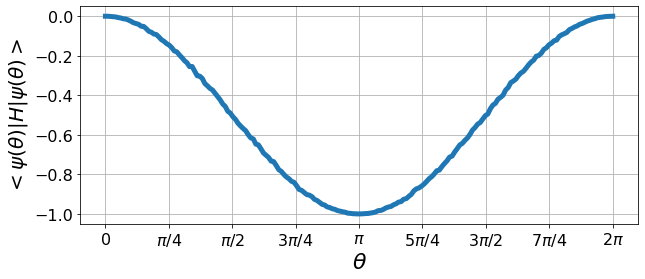

In [23]:
plt.figure(figsize = (10,4))
plt.plot(anglelist,E , linewidth=5)
plt.grid()


plt.xlabel(r'$\theta$', fontsize = 22)
plt.ylabel(r'$<{\psi(\theta)} | H |{\psi(\theta)} >$' , fontsize = 20)
plt.yticks(fontsize = 16)
plt.xticks([0.0, np.pi/4, np.pi/2, 3*np.pi/4 , np.pi, 5*np.pi/4 , 3*np.pi/2, 7*np.pi/4 , 2*np.pi],
           [r'$0$', r'$\pi/4$', r'$\pi/2$', r'$3\pi/4$', r'$\pi$', r'$5\pi/4$', r'$3\pi/2$' , r'$7\pi/4$', r'$2\pi$' ], fontsize = 16)
plt.show()

From the graph and the list of values stored in the list we can find the minimum eigenvalue of the matrix $H$

In [24]:
MimimumEigenvalue = np.amin(E)
print('The estimated minimum eigenvalue of the matrix H from VQE algorithm is: {}'.format(MimimumEigenvalue))

The estimated minimum eigenvalue of the matrix H from VQE algorithm is: -1.0


In [25]:
evalsH, eketsH =H.eigenstates()
MimimumEigenvalue_Exact  = np.amin(evalsH)
print('The exact minimum eigenvalue of the matrix H is: {}'.format(MimimumEigenvalue_Exact))

The exact minimum eigenvalue of the matrix H is: -0.9999999999999989


In [35]:
evalsH

array([-1.,  1.,  1.,  1.])

In [36]:
evalsH[0]

-0.9999999999999989

# References

[1] https://quantaggle.com/algorithms/algorithm/#VQE

[2] https://docs.microsoft.com/en-us/quantum/concepts/pauli-measurements

[3] https://www.youtube.com/watch?v=o4BAOKbcd3o&feature=youtu.be&list=PLOFEBzvs-VvrXTMy5Y2IqmSaUjfnhvBHR

[4] https://www.mustythoughts.com/variational-quantum-eigensolver-explained